In [17]:
import networkx as nx
import matplotlib.pyplot as plt
import os
import re
import csv
import sys
import json
import datetime
import requests
import difflib
RAW_DIR = "../raw/"
LIST_RAW_CSV = "../list_raw/all.csv"
LIST_RAW_JSON = "../transformed/all_json.json"
TRANSFORMED_DIR = "../transformed/"
OUTPUT = "output.txt"
GBTOUTPUT = "gbt.txt"
TITLEOUTPUT = "title.txt"

In [18]:
#
full_keys = ["author","title","journal","year","DOI","month","citations(google scholar)","abstract","keywords","reference_count","ccfClass","important","references"]
full_keys_default = {"author":[],"title":"","journal":"","year":0,"DOI":"","month":0,"citations(google scholar)":-1,"abstract":"","keywords":[],"reference_count":0,"ccfClass":"","important":None,"references":[]}
# 常用函数定义
# 调用crossref接口
def string_similar(s1, s2):
    return difflib.SequenceMatcher(None, s1, s2).ratio()
def get_crossref_info(ref):
    url = "https://doi.crossref.org/servlet/query"

    querystring = {"usr":"halloweenwx@163.com","pwd":"halloween","format":"json","qdata":"""<?xml version = "1.0" encoding="UTF-8"?>
    <query_batch version="2.0" xmlns = "http://www.crossref.org/qschema/2.0" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
      <head>
          <email_address>hisham@atypon.com</email_address>
          <doi_batch_id>Sample multi resolve</doi_batch_id>
      </head>
      <body>
           <query key="mykey" enable-multiple-hits="true">
      <unstructured_citation>"""+ref+"""</unstructured_citation>
    </query>
         </body>
    </query_batch>"""}

    headers = {
        'User-Agent': "PostmanRuntime/7.20.1",
        'Accept': "*/*",
        'Cache-Control': "no-cache",
        'Postman-Token': "123bedd6-8fb9-43e5-980a-54336e7aa684,6312f073-8e24-4222-abb2-789899bbc01f",
        'Host': "doi.crossref.org",
        'Accept-Encoding': "gzip, deflate",
        'Connection': "keep-alive",
        'cache-control': "no-cache"
        }
    response = requests.request("GET", url, headers=headers, params=querystring)
#     print(response.text)
    return response.text

# 保存至transform
def save_tran_json(addr,jsonfile):
    with open(TRANSFORMED_DIR + addr, 'w') as o:
        o.write(json.dumps(jsonfile,ensure_ascii=False))
        
def save_tran_plain(addr,txtfile):
    with open(TRANSFORMED_DIR + addr, 'w') as o:
        o.write(txtfile)
        
def save_tran_lines(addr,txtfile):
    with open(TRANSFORMED_DIR + addr, 'a+') as o:
        for line in txtfile:
            o.write(line+'\n')    
# 从transformd中读取
def read_tran_json(addr):
    with open(TRANSFORMED_DIR + addr,encoding = 'utf-8') as f:
        data = json.load(f)
    return data
    
#  查询ccf等级
def search_ccf(s):
    ccf_all_addr = "/Users/Halloween/Desktop/Study/复杂网络/lrcns/raw-data/ccf/ccf_all.csv"

    ccf_all = []
    ccf_search_res = {}
    with open(ccf_all_addr,encoding = 'utf-8') as f:
        reader = csv.reader(f)
        for line in reader:
            ccf_all.append(line)
    level = ""
    field = ""
    cORj = ""
    col = -1
#     print(ccf_all)
    for line in reversed(ccf_all):
        if col != 1 and col != 2 and col != -1:
            col = -1
            continue
        if col == -1:
            for word in line[1:3]:
                if word == "":
                    continue
                if(string_similar(word,s)>0.9):
                    col = line.index(word)
                    ccf_search_res['ccf_search_res'] = word
#                     print('"'+word.strip('"')+'"'+'"'+s.strip('"')+'"')
#                     print(col)
#                     print(line)
                    break
        else:
            if len(line[0])>1 and line[0][1]=='、' and level == "":
                level = line[0][2]
#                 print(level)
            if len(line[0])>10 and line[0][:2]=="中国" and field == "":
                field = line[0][line[0].find("（")+1:line[0].find("）")]
                cORj = line[0][line[0].find("术")+1:line[0].find("（")]
#                 print(field)
    ccf_search_res.update({"level":level,"field":field,"type":cORj})
    return {"level":level,"field":field,"type":cORj}
# 数据审查函数
def inspect(to_inspect):
    papers_arr = to_inspect
    all_error = 0
    for paper in papers_arr:
        inspect = []
        for key in full_keys:
            if(key not in paper.keys() or type(paper[key]) != type(full_keys_default[key]) or paper[key] == full_keys_default[key]):
                inspect.append(key + " lost")
                continue
            if(key == "author" or key == "keywords" or key == "references"):
                if(type(paper[key]) != list or len(paper[key])==0):
                    inspect.append(key + " lost")
                    continue
            if(key == "year"):
                if(paper[key]<1900):
                    inspect.append(key + " error")
            if(key == "month"):
                if(paper[key]<0 or paper[key] >12):
                    inspect.append(key + " error")
            if(key == "citations(google scholar)" or key == "reference_count"):
                if(paper[key]<0):
                    inspect.append(key + " error")
            if(key == 'ccfClass'):
                if(paper[key] not in ['A','B','C']):
                    inspect.append(key + " error")
            if(type(paper[key])==int):
                if(paper[key]<0):
                    inspect.append(key + " less than 0")
                continue
            if(type(paper[key])==float):
                inspect.append(key + " not int")
                continue
        paper['inspect'] = list(inspect)
        print(paper['title']+str(paper['inspect']))
        all_error += len(paper['inspect'])
    print(">>>>SUMMARY ERRORs:"+str(all_error)+"<<<<<")
    return papers_arr

In [76]:
union_arr = read_tran_json('union.txt')
print(len(union_arr))

498


In [74]:
list_tran_arr = read_tran_json('list_tran_arr.txt')
print(len(list_tran_arr))

453


In [73]:
cleaned_arr = read_tran_json('y_clean.txt')
print(len(cleaned_arr))

292


In [86]:
print(cleaned_arr[1]['references'][1]['cross'])

{
 "issued": {
 "date-parts": [
 2008
]
},
 "link": [
 {
 "intended-application": "crawler-based",
 "content-version": "vor",
 "content-type": "unspecified",
 "URL": "http://dl.acm.org/ft_gateway.cfm?id=1379104&amp;ftid=535163&amp;dwn=1"
}
],
 "score": 1,
 "prefix": "http://id.crossref.org/10.1145",
 "author": [
 {
 "family": "Golder",
 "given": "Scott"
}
],
 "container-title": "Proceedings of the nineteenth ACM conference on Hypertext and hypermedia - HT '08",
 "citedby-count": 13,
 "reference-count": 0,
 "page": "43",
 "deposited": {
 "date-parts": [
 2016,
 12,
 16
],
 "timestamp": 1481912487000
},
 "created": {
 "date-parts": [
 2008,
 6,
 24
],
 "issue": "",
 "title": "Measuring social networks with digital photograph collections",
 "subtitle": "",
 "type": "conference_paper",
 "DOI": "10.1145/1379092.1379104",
 "ISBN": [
 "9781595939852"
],
 "URL": "https://doi.org/10.1145/1379092.1379104",
 "source": "Crossref",
 "publisher": "Association for Computing Machinery (ACM)",
 "indexe

In [82]:
for paper in cleaned_arr:
    try:
        for ref in paper['references']:
            ref_doi = json.loads(ref['cross'])['created']['title']
            print(paper["title"]+";"+ref_doi)
    except:
        pass

Understanding Kin Relationships in a Photo;Toward Large-Scale Face Recognition Using Social Network Context
Understanding Kin Relationships in a Photo;Robust Real-Time Face Detection
Understanding Kin Relationships in a Photo;Unsupervised Joint Alignment of Complex Images
Understanding Kin Relationships in a Photo;Eigenfaces for Recognition
Understanding Kin Relationships in a Photo;Face recognition by independent component analysis
Understanding Kin Relationships in a Photo;Eigenfaces vs. Fisherfaces: recognition using class specific linear projection
Graph-based Kinship Recognition;Kin recognition and the perceived facial similarity of children
Graph-based Kinship Recognition;Towards computational models of kinship verification
Graph-based Kinship Recognition;Where are kin recognition signals in the human face?
Tri-Subject Kinship Verification: Understanding the Core of A Family;Query-Adaptive Image Search With Hash Codes
Tri-Subject Kinship Verification: Understanding the Core of A 

In [69]:
# 输出
author_set = set()
for paper in cleaned_arr:
    authors = list(paper['author'])
    for author in authors:
        for c in [';','；','，',',','and']:
            if(c in author):
                print(">>>>>><<<<<"+str(authors)+str(author.split(c)))
#                 print()
                paper['author'] = author.split(c)
    
        
    paper['author'] = [x.strip('\ufeff').strip('\xa0').replace('∗',"").strip(' ').strip('.*').strip('213').lower() for x in paper['author']]
    print(paper['author'])
#     for author in paper['author']:
#         print(author)

['scott a.golder']
['peng wu', 'weimin ding', 'zhidong mao', 'dan tretter']
['peng wu', 'dan tretter']
['siyu xia', 'ming shao', 'jiebo luo', 'yun fu']
['yan-ying chen', 'winston h. hsu', 'hong-yuan mark liao']
['afshin dehghan', 'enrique g. ortiz', 'ruben villegas', 'mubarak shah']
['yuanhao guo', 'hamdi dibeklio˘glu', 'laurens van der maaten']
['', 'songcan chen']
['qieyun dai', 'peter carr', 'leonid sigal', 'derek hoiem']
['joseph p. robinson', 'ming shao', 'yue wu', 'hongfu liu', 'timothy gillis', 'yun fu']
['xiuzhuang zhou', 'kai jin', 'min xu', 'guodong guo']
['haibin yan', 'shiwei wang']
['zhanpeng zhang', 'ping luo', 'chen change loy', 'xiaoou tang']
['qianru sun', 'bernt schiele', 'mario fritz']
['junnan li', 'yongkang wong', 'qi zhao', 'mohan s. kankanhalli']
['zhanpeng zhang', 'ping luo', 'chen change loy', 'xiaoou tang']
['zhouxiawang', 'tianshui chen', 'jimmy ren', 'weihao yu', 'hui cheng', 'liang lin']
['arushi goel', 'keng teck ma', 'cheston tan']
['emanuel s´anchez aima

In [87]:
for paper in cleaned_arr:
    print(paper['citations(google scholar)'])

37
16
34
172
39
77
49
65
10
15
7
0
54
31
13
27
16
0
0
0
145
59
5
6
0
19
13
1
2
0
5
19
8
1
37
85
7
1
0
1
121
169
92
105
72
93
13
16
10
0
3
0
6
1
5
5
0
0
10
1
0
2
22
8
1
37
11
5
1
2
21
2
75
13
23
21
1
11
94
19
19
64
4
6
0
2
18
48
160
0
24
0
15
17
59
1
0
0
24
1
6
1
91
240
6
16
19
5
0
84
18
29
40
11
15
0
0
0
4
17
55
13
68
14
1
17
3
27
29
1
12
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
54
28
265
695
2136
167
76
752
86
54
2175
501
1
0
4
5
1
139
1
72
53
733
507
1394
43
47
277
154
37
39
188
2
28
2
27
483
10
1915
0
0
0
7
7
5
8
13
7
26
1
132
22
26
206
35
67
3
3
0
37
37
10
159
8
22
34
8
10
9
5
690
27
88
53
2
7
89
131
0
0
0
11
0
582
0
52
0
3
26
0
67
40
146
146
69
20
2
0
0
539
27
2061
1
0
103
1656
48
64
0
64
0
47
85
11
20
24
291
2177
403
0
152
1524
2000
20
26
1478


In [28]:
G = nx.Graph()
# for paper in cleaned_arr:
#     G.add_node(paper['DOI'])
#     for ref in paper['references']:
#         try:
#             ref_doi = json.loads(ref['cross'])['created']['DOI']
#             G.add_node(ref_doi)
#         except:
#             print("error")
            
            
G.list

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error


AttributeError: 'Graph' object has no attribute 'list'

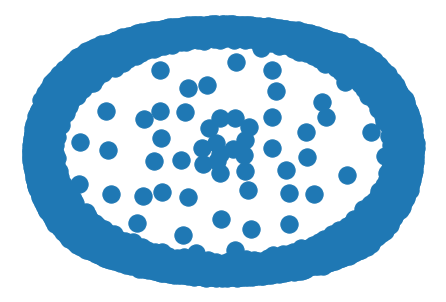

In [27]:
nx.draw(G)
plt.show()

In [88]:
wos500_arr = read_tran_json('wos500.txt')

In [100]:
wos500_title_set = set()
for paper in wos500_arr:
#     print(paper['TI'][0])
    wos500_title_set.add(paper['TI'][0])

KeyError: 'CN'

In [104]:
print(wos500_arr[0]['AB'])

['The graph-based algorithm for personalized recommendations mainly', 'depends on the user-item model to construct a bipartite graph. We can', 'provide recommendations by analyzing the bipartite graphs. However, for', 'personalized videos recommendations, the classical recommendation', 'algorithm based on graphs has low efficiency. Therefore, this paper', 'gives an improved video recommendation algorithm that is based on the', 'hyperlink-graph model. This method cannot only improve the accuracy of', 'the recommendations, but also reduce the running time. Furthermore, the', 'Internet users may have many different interests. For example, they may', 'be interested in sports videos, and at the same time also enjoy watching', 'political videos. For this reason, we propose a complement algorithm', 'based on hyperlink-graph model for video recommendations. This algorithm', 'is based on the principles of min-Hash. It realizes the cross clustering', 'in user layers and further improves the accu

In [98]:
cnt = 0
for paper in wos500_arr:
    if "a survey" in paper['TI'][0].lower():
        print(paper['TI'])
    


['A survey of recommendation techniques based on offline data processing']
['Research commentary on recommendations with side information: A survey', 'and research directions']
['Knowledge Graph Embedding: A Survey of Approaches and Applications']
['Routing correlated data in wireless sensor networks: A survey']
['A Survey of Overlapping Community Detection Based on Multi-Label', 'Propagation']
['Community Detection in Multi-Layer Graphs: A Survey']
['A survey on network community detection based on evolutionary', 'computation']
['A survey on community detection methods based on the nature of social', 'networks']
['A Survey of Social Network Analysis Techniques and their Applications to', 'Socially Aware Networking']
['A Survey on Network Embedding']
['The Applications of Stochastic Models in Network Embedding: A Survey']
['Virtual Network Embedding: A Survey']
['Information Diffusion in Online Social Networks: A Survey']
